In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dark-face-dataset/label/1893.txt
/kaggle/input/dark-face-dataset/label/1711.txt
/kaggle/input/dark-face-dataset/label/4682.txt
/kaggle/input/dark-face-dataset/label/5450.txt
/kaggle/input/dark-face-dataset/label/5064.txt
/kaggle/input/dark-face-dataset/label/3504.txt
/kaggle/input/dark-face-dataset/label/1773.txt
/kaggle/input/dark-face-dataset/label/559.txt
/kaggle/input/dark-face-dataset/label/1812.txt
/kaggle/input/dark-face-dataset/label/5993.txt
/kaggle/input/dark-face-dataset/label/1093.txt
/kaggle/input/dark-face-dataset/label/4417.txt
/kaggle/input/dark-face-dataset/label/4503.txt
/kaggle/input/dark-face-dataset/label/1356.txt
/kaggle/input/dark-face-dataset/label/2869.txt
/kaggle/input/dark-face-dataset/label/3926.txt
/kaggle/input/dark-face-dataset/label/2093.txt
/kaggle/input/dark-face-dataset/label/1880.txt
/kaggle/input/dark-face-dataset/label/3721.txt
/kaggle/input/dark-face-dataset/label/557.txt
/kaggle/input/dark-face-dataset/label/361.txt
/kaggle/input/da

In [2]:
!pip install piq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 3.5 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import colorsys
import matplotlib.colors as mcolors
import cv2
import scipy
from PIL import Image
import math
from sklearn.decomposition import PCA
import random
from tqdm import tqdm

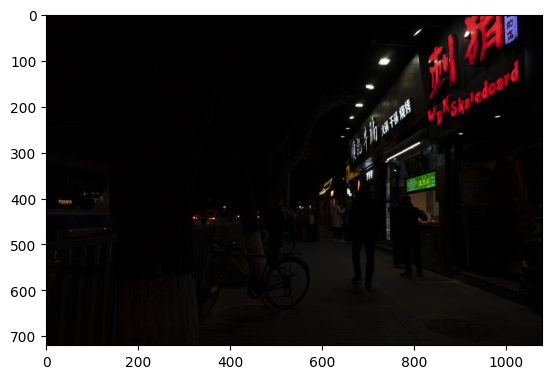

In [4]:
numb = 18
im = Image.open(f"/kaggle/input/dark-face-dataset/image/{numb}.png")
im = np.array(im)/255
plt.imshow(im)

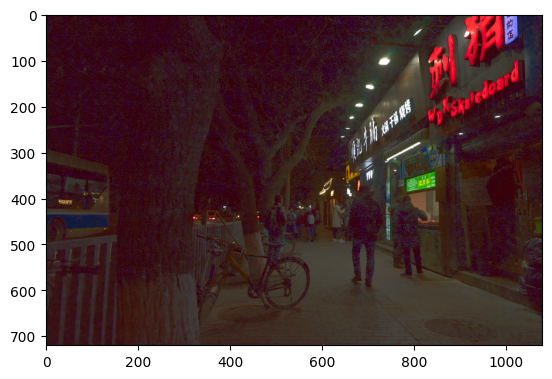

In [5]:
im_hsv = mcolors.rgb_to_hsv(im)
v = im_hsv[:,:,-1]
#pca = PCA()
#principle_components = pca.fit_transform(v)
#principle_components[:,256//2:] = 0
#v_reconstructed = pca.inverse_transform(principle_components)
#im_hsv[:,:,-1] = v
im_hsv[:,:,-1] += 0.2
im_rgb = mcolors.hsv_to_rgb(im_hsv)
plt.imshow(im_rgb)
#img_grey = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

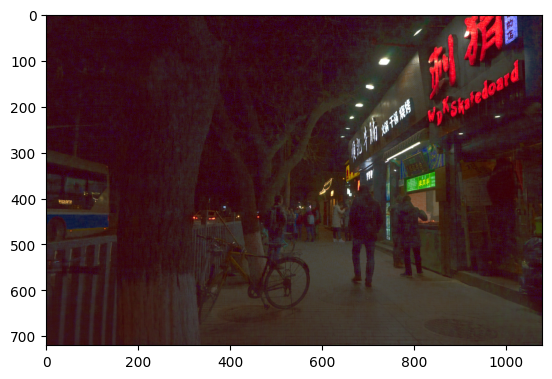

In [6]:
im_hsv = mcolors.rgb_to_hsv(im)

fract_principle_keep = 1/4
channel = 1
v = im_hsv[:,:,channel]

pca = PCA()
principle_components = pca.fit_transform(v)
principle_components[:,math.floor(fract_principle_keep*256):] = 0
v_reconstructed = pca.inverse_transform(principle_components)

#v_equalized = cv2.equalizeHist(v_reconstructed)

im_hsv[:,:,channel] = v_reconstructed
im_hsv[:,:,-1] += 0.2
im_rgb = mcolors.hsv_to_rgb(im_hsv)
plt.imshow(im_rgb)

Hyperparameters to adjust:

Saturation: s : Step 1 after split

Sharpness: sigmaColor, sigmaSpace : Step 4 and step 6

Contrast: gamma : Additional step to final image

Overall Brightness: brightness_boost : Additional step to final image

Retinex Intensity: gain : multi_scale_retinex function

Retinex Sigmas: sigmas : multi_scale_retinex and single_scale_retinex functions

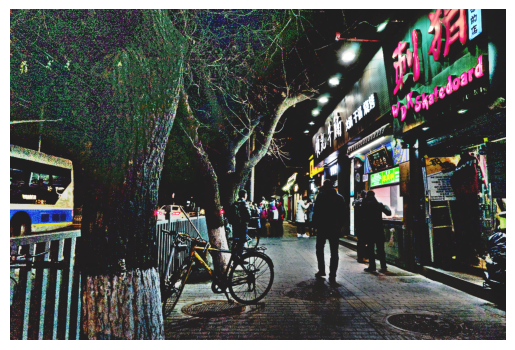

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread(f"/kaggle/input/dark-face-dataset/image/{numb}.png")

### Step 1: Dual-Channel Light Amplification in HSV
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv_image)
s = (s*0.85).astype(np.uint8)

# Apply CLAHE to the Value channel with controlled limits
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))  # Adjusted clipLimit
v_clahe = clahe.apply(v)

# Merge back the channels and convert to BGR
hsv_amplified = cv2.merge([h, s, v_clahe])
amplified_image = cv2.cvtColor(hsv_amplified, cv2.COLOR_HSV2BGR)

### Step 2: Color Contrast Enhancement with CLAHE on Each Channel
# Split the amplified image into BGR channels
b, g, r = cv2.split(amplified_image)

# Apply CLAHE to each channel with a controlled clip limit
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
b_clahe = clahe.apply(b)
g_clahe = clahe.apply(g)
r_clahe = clahe.apply(r)

# Merge enhanced channels back
contrast_enhanced_image = cv2.merge([b_clahe, g_clahe, r_clahe])

### Step 3: Multi-Scale Retinex for Signal Integration
def single_scale_retinex(image, sigma):
    log_image = np.log1p(image.astype(np.float32))
    blurred_image = cv2.GaussianBlur(image.astype(np.float32), (0, 0), sigma)
    log_blurred = np.log1p(blurred_image)
    return log_image - log_blurred

def multi_scale_retinex(image, sigmas=[10, 50, 100], gain = 1.0):
    retinex = np.zeros_like(image, dtype=np.float32)
    for sigma in sigmas:
        retinex += single_scale_retinex(image, sigma)
    retinex /= len(sigmas)
    # Adjust scaling here to avoid over-darkening
    retinex = np.clip(retinex * gain, -1, 1)
    retinex = np.expm1(retinex) * 255
    return retinex

# Apply multi-scale retinex on each channel separately
retinex_b = multi_scale_retinex(b_clahe)
retinex_g = multi_scale_retinex(g_clahe)
retinex_r = multi_scale_retinex(r_clahe)

# Stack channels back together and clip values to the valid range
retinex_image = cv2.merge([retinex_b, retinex_g, retinex_r])
retinex_image = np.clip(retinex_image, 0, 255).astype(np.uint8)

### Step 4: Noise Reduction with Edge Preservation
# Apply bilateral filter for noise reduction with edge preservation
denoised_image = cv2.bilateralFilter(retinex_image, d=9, sigmaColor=10, sigmaSpace=10)

### Step 5: Blend the Amplified and Original Image for a Natural Look
alpha = 0.7  # Blend ratio; adjust for stronger or weaker enhancement
final_image = cv2.addWeighted(denoised_image, alpha, image, 1 - alpha, 0)

final_image = cv2.bilateralFilter(final_image, d=5, sigmaColor=10, sigmaSpace=10)

def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Apply gamma correction to final image
final_image = adjust_gamma(final_image, gamma=1.2)  # Adjust gamma as needed

# Increase brightness by adding a fixed value
brightness_boost = 30  # Adjust this value between 20–40 as needed
final_image = cv2.convertScaleAbs(final_image, alpha=1, beta=brightness_boost)


# Display the result using matplotlib
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [8]:
def colorfulness(image):
    (B, G, R) = cv2.split(image.astype("float"))
    rg = np.absolute(R - G)
    yb = np.absolute(0.5 * (R + G) - B)
    std_rg, mean_rg = np.std(rg), np.mean(rg)
    std_yb, mean_yb = np.std(yb), np.mean(yb)
    return np.sqrt(std_rg**2 + std_yb**2) + 0.3 * np.sqrt(mean_rg**2 + mean_yb**2)

"""from skimage import img_as_float
from skimage.measure import niqe

image_float = img_as_float(final_image)
niqe_score = niqe(image_float)"""

def sharpness(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def contrast(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    min_intensity = np.min(gray)
    max_intensity = np.max(gray)
    return (max_intensity - min_intensity) / (max_intensity + min_intensity)

from skimage.measure import shannon_entropy

def entropy(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return shannon_entropy(gray)

def luminance_stats(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_luminance = np.mean(gray)
    std_luminance = np.std(gray)
    return mean_luminance, std_luminance


# Compute metrics for the final image
cf = colorfulness(final_image)
#niqe_score = niqe(img_as_float(final_image))
sharpness_score = sharpness(final_image)
contrast_score = contrast(final_image)
entropy_score = entropy(final_image)
mean_luminance, std_luminance = luminance_stats(final_image)

# Print results for evaluation
print("Colorfulness:", cf)
#print("NIQE Score:", niqe_score)
print("Sharpness:", sharpness_score)
print("Contrast:", contrast_score)
print("Entropy:", entropy_score)
print("Mean Luminance:", mean_luminance)
print("Std Luminance:", std_luminance)


Colorfulness: 43.084163250050295
Sharpness: 7857.916731009153
Contrast: 7.758620689655173
Entropy: 5.6745610237279696
Mean Luminance: 68.08493827160494
Std Luminance: 56.03758684489797


/tmp/ipykernel_17/582123577.py:23: RuntimeWarning: overflow encountered in scalar add
  return (max_intensity - min_intensity) / (max_intensity + min_intensity)


# Genetic Algorithm

In [9]:
#Define hyperparameters and their ranges
#Potential to add more retinex sigmas if necessary, maybe also a parameter to control how many sigmas are used.
param_ranges = {
    "Saturation": (0,1.0), #Initial saturation adjustment
    "CLAHE_clipLimit_Value": (1.0, 5.0), #Value CLAHE clip limit
    "CLAHE_clipLimit_BGR": (1.0, 5.0), #BGR CLAHE clip limit
    "Retinex_gain": (1.0, 3.0), #Retinex gain
    "Retinex_sigma1": (5,20),
    "Retinex_sigma2": (30,100),
    "Retinex_sigma3": (100, 250),
    "Blend_ratio": (0.0, 1.0),
    "gamma": (1.0, 1.5), #Gamma correction
    "brightness_boost": (20,40) #Brightness boost
    
}

def single_scale_retniex(image,sigma):
    log_image = np.log1p(image.astype(np.float32))
    blurred_image = cv2.GaussianBlur(image.astype(np.float32), (0,0), sigma)
    log_blurred = np.log1p(blurred_image)
    return log_image - log_blurred

def multi_scale_retinex(image, sigmas=[10, 50, 100], gain = 1.0):
    retinex = np.zeros_like(image, dtype=np.float32)
    for sigma in sigmas:
        retinex += single_scale_retinex(image, sigma)
    retinex /= len(sigmas)

    #Adjust scaling here to avoid over-darkening
    retinex = np.clip(retinex * gain, -1, 1)
    retinex = np.expm1(retinex) * 255
    return retinex

#Fitness function to evaluate the "naturalness" of an enhanced image
def fitness_function(params, orginal_image):
    #Apply image enhancement with params
    enhanced_image = apply_image_enhancement(original_image, params)

    #Calculate metrics for fitness evaluation (e.g., NIQE, sharpness, etc.)
    colorfulness_score = colorfulness(enhanced_image)
    sharpness_score = sharpness(enhanced_image)
    contrast_score = contrast(enhanced_image)
    entropy_score = entropy(enhanced_image)

    #Define target ranges for each metric (customizable)
    target_colorfulness = 30
    target_sharpness = 250
    target_contrast = 0.4
    target_entropy = 6

    contrast_norm = (contrast_score - 0.2) / (0.8 - 0.2)
    colorfulness_norm = (colorfulness_score - 10) / (50 - 10)
    sharpness_norm = (sharpness_score - 100) / (1000 - 100)
    entropy_norm = (entropy_score - 5) / (7.5 - 5)

    target_contrast_norm = (target_contrast - 0.2) / (0.8 - 0.2)
    target_colorfulness_norm = (target_colorfulness - 10) / (50 - 10)
    target_sharpness_norm = (target_sharpness - 100) / (1000 - 100)
    target_entropy_norm = (target_entropy - 5) / (7.5 - 5)


    #Calculate fitness score based on deviations from target values
    # maybe it would make more sense to replace with means squared instead of abs
    fitness = (
        abs(colorfulness_norm - target_colorfulness_norm) +
        abs(sharpness_norm - target_sharpness_norm) +
        abs(contrast_norm - target_contrast_norm) +
        abs(entropy_norm - target_entropy_norm)
    )
    return fitness


#Function to apply the enhancement algorithm with given hyperparameters
def apply_image_enhancement(image, params):
    #print(params.items())
    ### Step 1: Dual-Channel Light Amplification in HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    s = (s*params["Saturation"]).astype(np.uint8)

    #Apply CLAHE to the VAlue channel with controlled limits
    #print(params["CLAHE_clipLimit_Value"])
    clahe = cv2.createCLAHE(clipLimit = params["CLAHE_clipLimit_Value"], tileGridSize=(8, 8)) #Adjusted clipLimit
    v_clahe = clahe.apply(v)

    # Merge back the channels and convert to BGR
    hsv_amplified = cv2.merge([h, s, v_clahe])
    amplified_image = cv2.cvtColor(hsv_amplified, cv2.COLOR_HSV2BGR)

    ### Step 2: Color Contrast Enhancement with CLAHE on Each Channel
    #Split the amplified image into BGR channels
    b, g, r = cv2.split(amplified_image)

    # Apply CLAHE to each channel with a controlled clip limit
    clahe = cv2.createCLAHE(clipLimit = params["CLAHE_clipLimit_BGR"], tileGridSize=(8, 8))
    b_clahe = clahe.apply(b)
    g_clahe = clahe.apply(g)
    r_clahe = clahe.apply(r)

    # Merge enhanced channels back
    contrast_enhanced_image = cv2.merge([b_clahe, g_clahe, r_clahe])

    ### Step 3: Multi-Scale Retinex for Signal Integration
    #Make sure the retinex functions are defined
    # Apply multi-scale retinex on each channel separately
    retinex_b = multi_scale_retinex(b_clahe, sigmas = [params["Retinex_sigma1"], params["Retinex_sigma2"], params["Retinex_sigma3"]], gain = params["Retinex_gain"])
    retinex_g = multi_scale_retinex(g_clahe, sigmas = [params["Retinex_sigma1"], params["Retinex_sigma2"], params["Retinex_sigma3"]], gain = params["Retinex_gain"])
    retinex_r = multi_scale_retinex(r_clahe, sigmas = [params["Retinex_sigma1"], params["Retinex_sigma2"], params["Retinex_sigma3"]], gain = params["Retinex_gain"])

    #Stack channels back together and clip values to the valid range
    retinex_image = cv2.merge([retinex_b, retinex_g, retinex_r])
    retinex_image = np.clip(retinex_image, 0, 255).astype(np.uint8)

    ### Step 4: Noise Reduction with Edge Preservation
    # Apply bilateral filter for noise reduction with edge preservation
    denoised_image = cv2.bilateralFilter(retinex_image, d=9, sigmaColor=10, sigmaSpace=10) #Potentially three more hyperparameters

    ### Step 5: Blend the Amplified and Original Image for a Natural Look
    alpha = params["Blend_ratio"] # Blend ratio; adjust for stronger or weaker enhancement
    final_image = cv2.addWeighted(denoised_image, alpha, image, 1-alpha, 0)

    final_image = cv2.bilateralFilter(final_image, d=5, sigmaColor=10, sigmaSpace=10)

    def adjust_gamma(image, gamma=1.2):
        invGamma = 1.0 / gamma
        table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(0,256)]).astype("uint8")
        return cv2.LUT(image, table)

    #Apply gamma correction to final image
    final_image = adjust_gamma(final_image, gamma = params["gamma"])
    
    #Increase brightness by adding a fixed value
    brightness_boost = params["brightness_boost"] #Adjust from between 20-40
    enhanced_image = cv2.convertScaleAbs(final_image, alpha=1, beta=brightness_boost)

    return enhanced_image

# Initialize population
def initialize_population(size):
    population = []
    for _ in range(size):
        individual = {key: random.uniform(*value) for key, value in param_ranges.items()}
        population.append(individual)
    return population

# Selection (select the top individuals based on fitness)
def selection(population, fitness_scores, num_parents):
    selected_parents = [population[i] for i in np.argsort(fitness_scores)[:num_parents]]
    return selected_parents

#Crossover (combine two parents to create an offspring)
def crossover(parent1, parent2):
    child = {}
    for key in parent1.keys():
        child[key] = parent1[key] if random.random() < 0.5 else parent2[key]
    return child

# Mutation (randomly change a parameter within its range)
def mutate(individual, mutation_rate=0.1):
    for key in individual.keys():
        if random.random() < mutation_rate:
            individual[key] = random.uniform(*param_ranges[key])
    return individual

#Main genetic algorithm
def genetic_algorithm(image, population_size=20, generations=10, num_parents=10, mutation_rate = 0.1):
    population = initialize_population(population_size)

    for generation in tqdm(range(generations)):
        #Evaluate fitness of each individual
        fitness_scores = [fitness_function(ind, image) for ind in population]

        #Selection: Select top individuals to be parents
        parents = selection(population, fitness_scores, num_parents)

        # Generate next generation
        new_population = []
        while len(new_population) < population_size:
            #Crossover
            parent1, parent2 = random.sample(parents,2)
            child = crossover(parent1, parent2)
            #Mutation
            child = mutate(child, mutation_rate)
            new_population.append(child)

        population = new_population

        #Print the best scores of the current generation
        best_score = min(fitness_scores)
        print(f"Generation {generation +1}: Best Fitness Score = {best_score}")

    # Return the best solution
    best_individual = population[np.argmin(fitness_scores)]
    return best_individual

#Load original image
no = 18
original_image = cv2.imread(f"/kaggle/input/dark-face-dataset/image/{no}.png")

population_size=20
generations=10
num_parents=10
mutation_rate = 0.25

#Run genetic algorithm
best_params = genetic_algorithm(original_image, population_size, generations, num_parents, mutation_rate)
print("Best Hyperparameters:", best_params)

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_17/582123577.py:23: RuntimeWarning: overflow encountered in scalar add
  return (max_intensity - min_intensity) / (max_intensity + min_intensity)
 10%|█         | 1/10 [00:48<07:19, 48.83s/it]

Generation 1: Best Fitness Score = 10.762928781084485


 20%|██        | 2/10 [01:37<06:28, 48.57s/it]

Generation 2: Best Fitness Score = 10.674154942464407


 30%|███       | 3/10 [02:29<05:52, 50.33s/it]

Generation 3: Best Fitness Score = 10.662007820145623


 40%|████      | 4/10 [03:22<05:09, 51.50s/it]

Generation 4: Best Fitness Score = 9.846491574315793


 50%|█████     | 5/10 [04:11<04:12, 50.46s/it]

Generation 5: Best Fitness Score = 9.92383572293541


 60%|██████    | 6/10 [04:57<03:15, 48.90s/it]

Generation 6: Best Fitness Score = 9.837156236358425


 70%|███████   | 7/10 [05:43<02:23, 47.85s/it]

Generation 7: Best Fitness Score = 9.067324873893078


 80%|████████  | 8/10 [06:28<01:34, 47.18s/it]

Generation 8: Best Fitness Score = 10.600716024384996


 90%|█████████ | 9/10 [07:17<00:47, 47.49s/it]

Generation 9: Best Fitness Score = 9.196602696015475


100%|██████████| 10/10 [08:07<00:00, 48.71s/it]

Generation 10: Best Fitness Score = 9.082576291112376
Best Hyperparameters: {'Saturation': 0.5441451053825277, 'CLAHE_clipLimit_Value': 2.4518346882592756, 'CLAHE_clipLimit_BGR': 4.514423805838561, 'Retinex_gain': 1.376573237715846, 'Retinex_sigma1': 10.19340974084012, 'Retinex_sigma2': 76.67204500263972, 'Retinex_sigma3': 151.1572586595686, 'Blend_ratio': 0.7515443297260589, 'gamma': 1.1259007804422745, 'brightness_boost': 39.600829505894986}


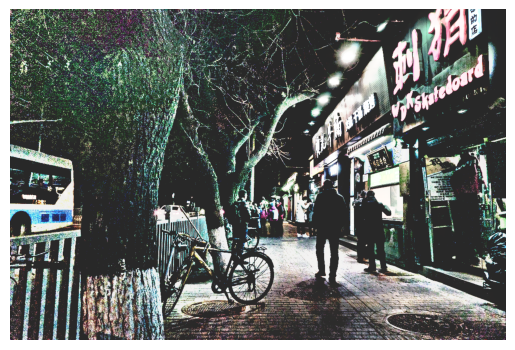

Colorfulness: 29.24261721917378
Sharpness: 12683.225590651788
Contrast: 5.512820512820513
Entropy: 4.948490782317448
Mean Luminance: 89.2421913580247
Std Luminance: 72.75995654529812


/tmp/ipykernel_17/582123577.py:23: RuntimeWarning: overflow encountered in scalar add
  return (max_intensity - min_intensity) / (max_intensity + min_intensity)


In [10]:
best_image = apply_image_enhancement(original_image, best_params)

plt.imshow(cv2.cvtColor(best_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Compute metrics for the final image
cf = colorfulness(best_image)
#niqe_score = niqe(img_as_float(final_image))
sharpness_score = sharpness(best_image)
contrast_score = contrast(best_image)
entropy_score = entropy(best_image)
mean_luminance, std_luminance = luminance_stats(best_image)

# Print results for evaluation
print("Colorfulness:", cf)
#print("NIQE Score:", niqe_score)
print("Sharpness:", sharpness_score)
print("Contrast:", contrast_score)
print("Entropy:", entropy_score)
print("Mean Luminance:", mean_luminance)
print("Std Luminance:", std_luminance)

# Validation

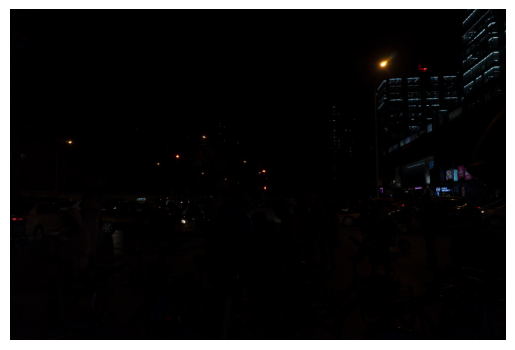

In [11]:
numb2 = 200
val_Image = cv2.imread(f"/kaggle/input/dark-face-dataset/image/{numb2}.png")
plt.imshow(cv2.cvtColor(val_Image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

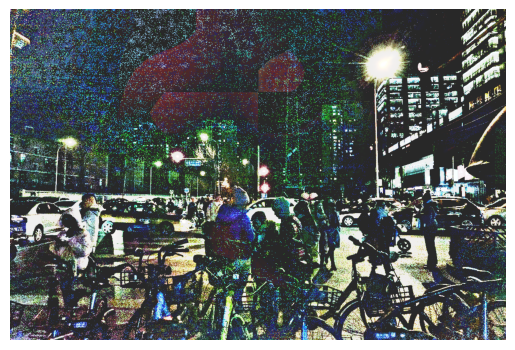

Colorfulness: 52.13575952455149
Sharpness: 18609.7690500918
Contrast: 5.512820512820513
Entropy: 4.520085475079841
Mean Luminance: 79.62706404320987
Std Luminance: 66.89753254334093


/tmp/ipykernel_17/582123577.py:23: RuntimeWarning: overflow encountered in scalar add
  return (max_intensity - min_intensity) / (max_intensity + min_intensity)


In [12]:
val_Image_best = apply_image_enhancement(val_Image, best_params)

plt.imshow(cv2.cvtColor(val_Image_best, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Compute metrics for the final image
cf = colorfulness(val_Image_best)
#niqe_score = niqe(img_as_float(final_image))
sharpness_score = sharpness(val_Image_best)
contrast_score = contrast(val_Image_best)
entropy_score = entropy(val_Image_best)
mean_luminance, std_luminance = luminance_stats(val_Image_best)

# Print results for evaluation
print("Colorfulness:", cf)
#print("NIQE Score:", niqe_score)
print("Sharpness:", sharpness_score)
print("Contrast:", contrast_score)
print("Entropy:", entropy_score)
print("Mean Luminance:", mean_luminance)
print("Std Luminance:", std_luminance)

# Misc

In [13]:
dark_images = tf.keras.preprocessing.image_dataset_from_directory('/kaggle/input/dark-face-dataset', batch_size=None, interpolation='nearest')

Found 6000 files belonging to 2 classes.


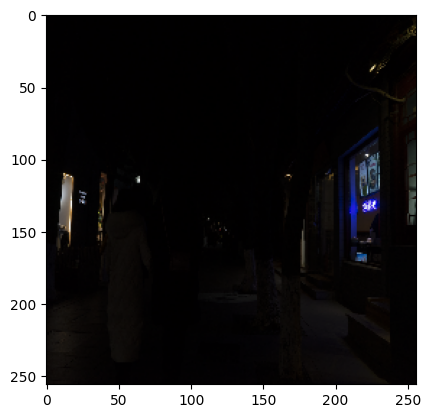

In [14]:
for i, label in dark_images.take(1):
    image = i
    plt.imshow(i)

In [15]:
from sklearn.decomposition import PCA
import math as m

In [16]:
np.cos(image.numpy()+10)

array([[[ 0.8438  ,  0.004425,  0.004425],
        [ 0.8438  ,  0.004425,  0.004425],
        [ 0.004425, -0.839   ,  0.004425],
        ...,
        [ 0.907   ,  0.004425,  0.004425],
        [-0.76    ,  0.907   ,  0.8438  ],
        [-0.9575  ,  0.8438  ,  0.004425]],

       [[ 0.8438  ,  0.004425,  0.004425],
        [ 0.8438  , -0.839   ,  0.004425],
        [ 0.004425, -0.839   ,  0.004425],
        ...,
        [ 0.907   ,  0.004425,  0.8438  ],
        [ 0.1367  ,  0.8438  ,  0.004425],
        [ 0.66    ,  0.1367  ,  0.8438  ]],

       [[ 0.004425, -0.839   , -0.839   ],
        [ 0.004425, -0.839   ,  0.004425],
        [ 0.004425, -0.839   ,  0.004425],
        ...,
        [ 0.907   ,  0.004425,  0.8438  ],
        [ 0.989   , -0.76    ,  0.8438  ],
        [-0.9624  , -0.548   ,  0.1367  ]],

       ...,

       [[ 0.424   ,  0.4082  ,  0.989   ],
        [-0.5327  ,  0.4082  ,  0.989   ],
        [ 0.424   ,  0.4082  ,  0.4082  ],
        ...,
        [ 0.907   ,  0.843

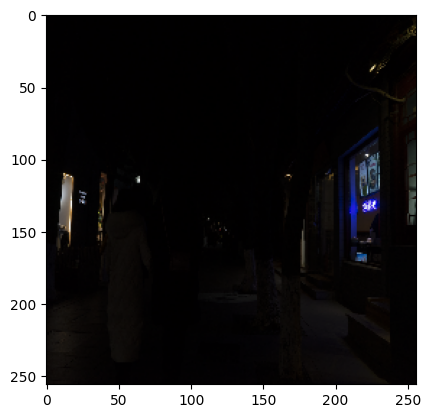

In [17]:
plt.imshow(image.numpy())

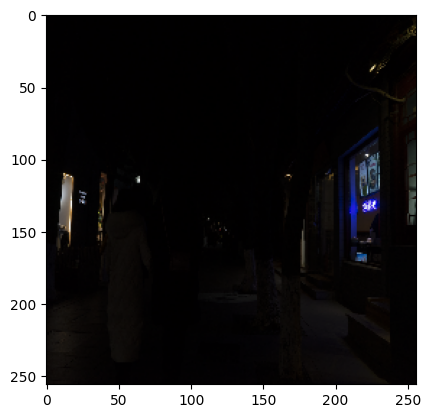

In [18]:
image_np = image.numpy()
#image_tr =
plt.imshow(image_np)
plt.show()

In [19]:
image_np.shape

(256, 256, 3)

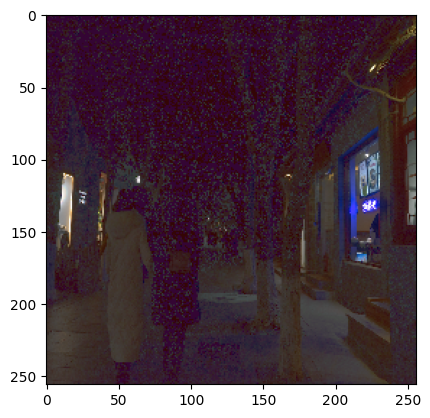

In [20]:
image_hsv = mcolors.rgb_to_hsv(image_np/255)
#image_hsl = np.array(image_hsl).T
image_hsv.shape
image_hsv[:,:,2] += 0.2
image_hsv[:,:,1] -= 0.1
#image_hsv[:,:,0] -= 0.01
image_rgb = mcolors.hsv_to_rgb(image_hsv)
plt.imshow(image_rgb)

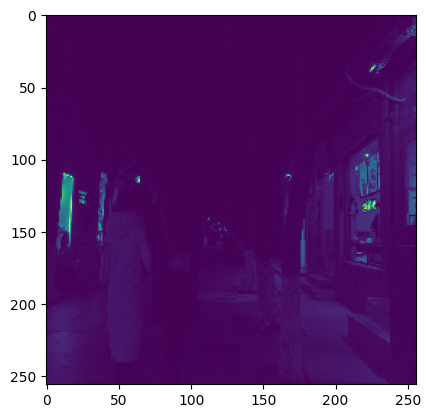

In [21]:
plt.imshow(image[:,:,0])

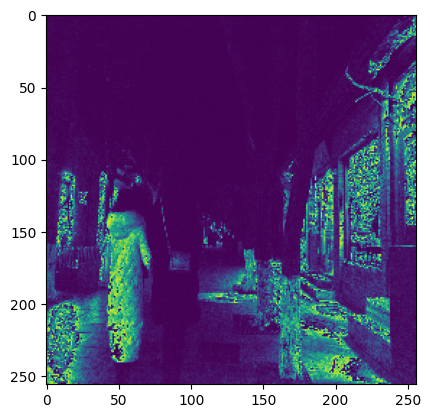

In [22]:
pca = PCA()
principle_components = pca.fit_transform(image.numpy()[:,:,0]**2)
principle_components[:,[]] = 0
image_reconstructed = pca.inverse_transform(principle_components)
plt.imshow(image_reconstructed)

In [23]:
def pca_rgb(image, indexes_to_toss = []):
    pca_rgb_im = []
    for i in range(image.shape[-1]):
        pca = PCA()
        principle_components_i = pca.fit_transform(image[:,:,i])
        principle_components_i[:,indexes_to_toss] = 0
        image_reconstructed_i = pca.inverse_transform(principle_components)
        pca_rgb_im.append(image_reconstructed_i)
    return np.transpose(np.array(pca_rgb_im))

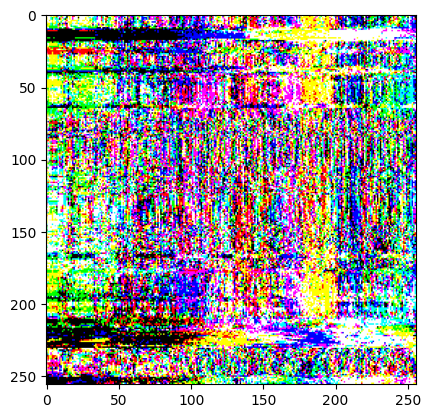

In [24]:
pca_rgb_im = pca_rgb(image.numpy())
plt.imshow(pca_rgb_im[:,:,:])

In [25]:
pca_rgb_im.shape

(256, 256, 3)

In [26]:
from sklearn.decomposition import PCA
import numpy as np

def pca_3d_image(image, indexes_to_toss):
    # Reshape image to a 2D array where each row is a pixel and each column is a color channel
    h, w, c = image.shape
    image_reshaped = image.reshape(-1, c)
    
    # Apply PCA on the flattened image
    pca = PCA()
    principal_components = pca.fit_transform(image_reshaped)
    
    # Set specified principal components to zero
    principal_components[:, indexes_to_toss] = 0
    
    # Reconstruct the image
    image_reconstructed = pca.inverse_transform(principal_components)
    
    # Reshape back to the original image shape
    image_reconstructed = image_reconstructed.reshape(h, w, c)
    
    return image_reconstructed
